In [2]:
import transformers
import torch
from transformers import WhisperFeatureExtractor, set_seed, AutoModelForAudioClassification
import datasets
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel
import pandas as pd
from tqdm import tqdm
import numpy as np
import librosa
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from os.path import isfile, join
tqdm.pandas()
set_seed(55)

# Read audio

In [3]:
def read_audio(path):
    try:
        audio, sample_rate = librosa.load(path, sr=16000)
        return audio
    except:
        return np.array([])

In [40]:
manifest = pd.read_excel('manifest_balanced.xlsx')
manifest = manifest[['path', 'Variant', 'text']]
manifest['array'] = manifest['path'].progress_apply(read_audio)
manifest['sampling_rate'] = 16000

100%|██████████████████████████████████████████████████████████████████████████| 55657/55657 [1:16:08<00:00, 12.18it/s]


# Split on train, validation and test

In [41]:
manifest = manifest[['path', 'Variant', 'array', 'sampling_rate']]
train = pd.DataFrame()
valid = pd.DataFrame()
test = pd.DataFrame()
for variant in list(manifest['Variant'].unique()):
    train_df, valid_test_df = train_test_split(manifest[manifest['Variant']==variant], test_size=0.3, random_state=55)
    valid_df, test_df = train_test_split(valid_test_df, test_size=0.5, random_state=55)
    train = pd.concat([train, train_df])
    valid = pd.concat([valid, valid_df])
    test = pd.concat([test, test_df])
train = train[train['array'].str.len()>0]
valid = valid[valid['array'].str.len()>0]
test = test[test['array'].str.len()>0]
try:
    del manifest
    del train_df
    del valid_test_df
    del valid_df
    del test_df
except:
    pass
gc.collect()

189

In [4]:
unique_labels = ['Arkhangelskie', 'Desninskie', 'Donskie', 'Kostromskie', 'Mezhzonalnie', 'Novgorodskie', 'Povolzkie',
                 'Pskovskie', 'Ryazanskie', 'Seligerskie']
label2id = {label: index for index, label in enumerate(unique_labels)}
id2label = {index: label for index, label in enumerate(unique_labels)}

In [43]:
test = test[['array', 'Variant']]

# Extract features from audio (only test split)

In [5]:
def prepare_dataset(array):
    input_features = feature_extractor(array, sampling_rate=16000, return_tensors='pt').input_features[0]
    return input_features
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-tiny")

In [45]:
test = test[['array', 'Variant']]
test['input_features'] = test['array'].progress_apply(prepare_dataset)

100%|█████████████████████████████████████████████████████████████████████████████| 8152/8152 [00:30<00:00, 264.20it/s]


# Define functions for testing

In [6]:
def get_predictions(array):
    global model, id2label
    outputs = model(torch.unsqueeze(array, 0))
    predicted_class_ids = torch.argmax(outputs.logits)
    return id2label[predicted_class_ids.item()]

In [7]:
def confusion_matrix(y_test, y_pred):
    labels = ['Архангельские', 'Верхне-Деснинские', 'Донские', 'Костромские', 'Межзональная группа Б',
        'Новгородские', 'Владимирско-Поволжские', 'Псковские', 'Рязанские', 'Селигеро-Торжковские']
    df_cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), index = labels, columns = labels)
    plt.figure(figsize=(8,6))
    ax = plt.subplot()
    sns.heatmap(df_cm, annot=True, cmap="binary", fmt='g', ax=ax)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.tight_layout()
    plt.show()

# Whisper tiny fine-tuned

In [29]:
model = AutoModelForAudioClassification.from_pretrained('/whisper-tiny-finetuned-rudialect/model')
device = "cpu"
model.to(device)

WhisperForAudioClassification(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 384, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(384, 384, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 384)
    (layers): ModuleList(
      (0-3): 4 x WhisperEncoderLayer(
        (self_attn): WhisperSdpaAttention(
          (k_proj): Linear(in_features=384, out_features=384, bias=False)
          (v_proj): Linear(in_features=384, out_features=384, bias=True)
          (q_proj): Linear(in_features=384, out_features=384, bias=True)
          (out_proj): Linear(in_features=384, out_features=384, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (final_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_

In [13]:
test['predictions'] = test['input_features'].progress_apply(get_predictions)

100%|██████████████████████████████████████████████████████████████████████████████| 8152/8152 [10:43<00:00, 12.66it/s]


In [14]:
print(classification_report(test['Variant'], test['predictions']))

               precision    recall  f1-score   support

Arkhangelskie       0.99      0.96      0.97       622
   Desninskie       0.99      0.99      0.99       705
      Donskie       1.00      0.99      1.00      1145
  Kostromskie       0.98      0.99      0.99      1195
 Mezhzonalnie       0.97      0.99      0.98       611
 Novgorodskie       0.97      0.95      0.96       568
    Povolzkie       0.99      0.98      0.99      1059
    Pskovskie       0.98      0.97      0.97       971
   Ryazanskie       0.95      0.97      0.96       609
  Seligerskie       0.98      0.99      0.98       667

     accuracy                           0.98      8152
    macro avg       0.98      0.98      0.98      8152
 weighted avg       0.98      0.98      0.98      8152



# Testing the dependence of prediction on fragment length

In [20]:
test_df_manifest = manifest.join(test, how='inner', lsuffix='_manifest', rsuffix='_test')

In [23]:
def segment_type(duration):
    if duration>0 and duration<=5:
        return '0-5 seconds'
    elif duration>5 and duration<=10:
        return '5-10 seconds'
    elif duration>10 and duration<=15:
        return '10-15 seconds'
    elif duration>15 and duration<=20:
        return '15-20 seconds'
    elif duration>20:
        return '20-30 seconds'

In [24]:
test_df_manifest['duration_type'] = test_df_manifest['duration'].progress_apply(segment_type)

100%|██████████████████████████████████████████████████████████████████████████| 8152/8152 [00:00<00:00, 741401.76it/s]


In [29]:
print(classification_report(test_df_manifest[test_df_manifest['duration_type'] == '0-5 seconds']['Variant_test'], 
                            test_df_manifest[test_df_manifest['duration_type'] == '0-5 seconds']['predictions']))

               precision    recall  f1-score   support

Arkhangelskie       0.98      0.94      0.96       319
   Desninskie       0.98      0.99      0.98       381
      Donskie       0.99      0.99      0.99       938
  Kostromskie       0.98      0.98      0.98       956
 Mezhzonalnie       0.96      0.98      0.97       372
 Novgorodskie       0.94      0.90      0.92       291
    Povolzkie       0.99      0.98      0.98       828
    Pskovskie       0.97      0.96      0.97       675
   Ryazanskie       0.93      0.96      0.94       375
  Seligerskie       0.95      0.97      0.96       283

     accuracy                           0.97      5418
    macro avg       0.97      0.97      0.97      5418
 weighted avg       0.97      0.97      0.97      5418



In [30]:
print(classification_report(test_df_manifest[test_df_manifest['duration_type'] == '5-10 seconds']['Variant_test'], 
                            test_df_manifest[test_df_manifest['duration_type'] == '5-10 seconds']['predictions']))

               precision    recall  f1-score   support

Arkhangelskie       0.99      0.99      0.99       194
   Desninskie       1.00      1.00      1.00       260
      Donskie       1.00      1.00      1.00       202
  Kostromskie       1.00      1.00      1.00       235
 Mezhzonalnie       0.99      0.99      0.99       183
 Novgorodskie       0.99      0.99      0.99       160
    Povolzkie       1.00      1.00      1.00       227
    Pskovskie       0.99      0.97      0.98       238
   Ryazanskie       0.97      1.00      0.98       115
  Seligerskie       0.99      0.99      0.99       309

     accuracy                           0.99      2123
    macro avg       0.99      0.99      0.99      2123
 weighted avg       0.99      0.99      0.99      2123



In [31]:
print(classification_report(test_df_manifest[test_df_manifest['duration_type'] == '10-15 seconds']['Variant_test'], 
                            test_df_manifest[test_df_manifest['duration_type'] == '10-15 seconds']['predictions']))

               precision    recall  f1-score   support

Arkhangelskie       1.00      0.98      0.99        54
   Desninskie       1.00      1.00      1.00        47
      Donskie       1.00      1.00      1.00         5
  Kostromskie       1.00      1.00      1.00         4
 Mezhzonalnie       1.00      1.00      1.00        47
 Novgorodskie       1.00      1.00      1.00        72
    Povolzkie       1.00      1.00      1.00         4
    Pskovskie       1.00      1.00      1.00        48
   Ryazanskie       0.97      1.00      0.99        37
  Seligerskie       1.00      1.00      1.00        68

     accuracy                           1.00       386
    macro avg       1.00      1.00      1.00       386
 weighted avg       1.00      1.00      1.00       386



In [32]:
print(classification_report(test_df_manifest[test_df_manifest['duration_type'] == '15-20 seconds']['Variant_test'], 
                            test_df_manifest[test_df_manifest['duration_type'] == '15-20 seconds']['predictions']))

               precision    recall  f1-score   support

Arkhangelskie       1.00      1.00      1.00        35
   Desninskie       1.00      1.00      1.00        10
 Mezhzonalnie       1.00      1.00      1.00         4
 Novgorodskie       1.00      1.00      1.00        30
    Pskovskie       1.00      1.00      1.00         5
   Ryazanskie       1.00      1.00      1.00        38
  Seligerskie       1.00      1.00      1.00         6

     accuracy                           1.00       128
    macro avg       1.00      1.00      1.00       128
 weighted avg       1.00      1.00      1.00       128



In [33]:
print(classification_report(test_df_manifest[test_df_manifest['duration_type'] == '20-30 seconds']['Variant_test'], 
                            test_df_manifest[test_df_manifest['duration_type'] == '20-30 seconds']['predictions']))

               precision    recall  f1-score   support

Arkhangelskie       1.00      0.95      0.97        20
   Desninskie       1.00      1.00      1.00         7
 Mezhzonalnie       1.00      1.00      1.00         5
 Novgorodskie       1.00      1.00      1.00        15
    Povolzkie       0.00      0.00      0.00         0
    Pskovskie       1.00      1.00      1.00         5
   Ryazanskie       1.00      1.00      1.00        44
  Seligerskie       1.00      1.00      1.00         1

     accuracy                           0.99        97
    macro avg       0.88      0.87      0.87        97
 weighted avg       1.00      0.99      0.99        97



C:\Users\Katya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Katya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Katya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


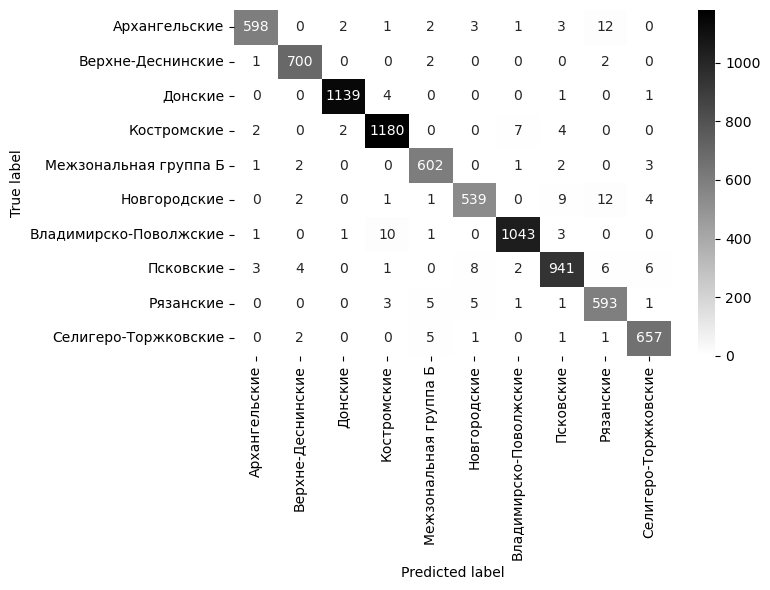

In [36]:
confusion_matrix(test['Variant'], test['predictions'])

In [37]:
test_df_manifest[test_df_manifest['Variant_test'] != test_df_manifest['predictions']].to_excel('whisper_finetuned_errors.xlsx')

## Test on data which not presented in dataset

## Yelets

In [39]:
yelets = pd.read_excel('manifest.xlsx')
yelets = yelets[yelets['corpus']=='Yelets']
yelets['Variant'] = 'Mezhzonalnie'
yelets = yelets[['path', 'Variant']]
yelets['array'] = yelets['path'].progress_apply(read_audio)
yelets['sampling_rate'] = 16000
yelets = yelets[['array', 'Variant']]
yelets['input_features'] = yelets['array'].progress_apply(prepare_dataset)

100%|███████████████████████████████████████████████████████████████████████████████| 522/522 [00:01<00:00, 275.40it/s]


In [40]:
yelets['predictions'] = yelets['input_features'].progress_apply(get_predictions)

100%|████████████████████████████████████████████████████████████████████████████████| 522/522 [00:41<00:00, 12.66it/s]


In [45]:
yelets['predictions'].value_counts()

Ryazanskie       384
Pskovskie         71
Donskie           19
Povolzkie         17
Kostromskie       15
Arkhangelskie     11
Novgorodskie       2
Seligerskie        2
Mezhzonalnie       1
Name: predictions, dtype: int64

## Pskov

In [23]:
path1 = '/RNC_Pskov/pskov_luch'
pskov1 = [join(path2, f) for f in listdir(path1) if isfile(join(path1, f))]
path2 = '/RNC_Pskov/pskov_vedma'
pskov2 = [join(path2, f) for f in listdir(path2) if isfile(join(path2, f))]
pskov_test_rnc = pskov1 + pskov2
pskov_test_rnc_df = pd.DataFrame(pskov_test_rnc, columns=['path'])
pskov_test_rnc_df['Variant'] = 'Pskovskie'
pskov_test_rnc_df['array'] = pskov_test_rnc_df['path'].progress_apply(read_audio)
pskov_test_rnc_df['sampling_rate'] = 16000
pskov_test_rnc_df = pskov_test_rnc_df[['array', 'Variant']]
pskov_test_rnc_df['input_features'] = pskov_test_rnc_df['array'].progress_apply(prepare_dataset)

  0%|                                                                                           | 0/68 [00:00<?, ?it/s]C:\Users\Katya\anaconda3\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|███████▎                                                                           | 6/68 [00:00<00:09,  6.70it/s]C:\Users\Katya\anaconda3\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 362.09it/s]


In [26]:
pskov_test_rnc_df = pskov_test_rnc_df[pskov_test_rnc_df['array'].str.len()>0]

In [32]:
pskov_test_rnc_df['predictions'] = pskov_test_rnc_df['input_features'].progress_apply(get_predictions)

100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:04<00:00, 13.15it/s]
C:\Users\Katya\AppData\Local\Temp\ipykernel_10180\1484875630.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pskov_test_rnc_df['predictions'] = pskov_test_rnc_df['input_features'].progress_apply(get_predictions)


In [33]:
pskov_test_rnc_df['predictions'].value_counts()

Donskie          29
Povolzkie        19
Pskovskie         9
Arkhangelskie     4
Kostromskie       2
Ryazanskie        2
Name: predictions, dtype: int64

# Whisper tiny fine-tuned (denoised)

In [8]:
model = AutoModelForAudioClassification.from_pretrained('/whisper-tiny-finetuned-rudialect-denoised/model')
device = "cpu"
model.to(device)
test['predictions'] = test['input_features'].progress_apply(get_predictions)

WhisperForAudioClassification(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 384, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(384, 384, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 384)
    (layers): ModuleList(
      (0-3): 4 x WhisperEncoderLayer(
        (self_attn): WhisperSdpaAttention(
          (k_proj): Linear(in_features=384, out_features=384, bias=False)
          (v_proj): Linear(in_features=384, out_features=384, bias=True)
          (q_proj): Linear(in_features=384, out_features=384, bias=True)
          (out_proj): Linear(in_features=384, out_features=384, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (final_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_

In [49]:
print(classification_report(test['Variant'], test['predictions']))

               precision    recall  f1-score   support

Arkhangelskie       0.53      0.98      0.69       622
   Desninskie       1.00      0.60      0.75       705
      Donskie       0.98      0.93      0.96      1145
  Kostromskie       0.94      0.92      0.93      1195
 Mezhzonalnie       0.96      0.80      0.87       611
 Novgorodskie       0.77      0.83      0.80       568
    Povolzkie       0.93      0.95      0.94      1059
    Pskovskie       0.88      0.85      0.87       971
   Ryazanskie       0.72      0.72      0.72       609
  Seligerskie       0.96      0.84      0.90       667

     accuracy                           0.86      8152
    macro avg       0.87      0.84      0.84      8152
 weighted avg       0.89      0.86      0.86      8152



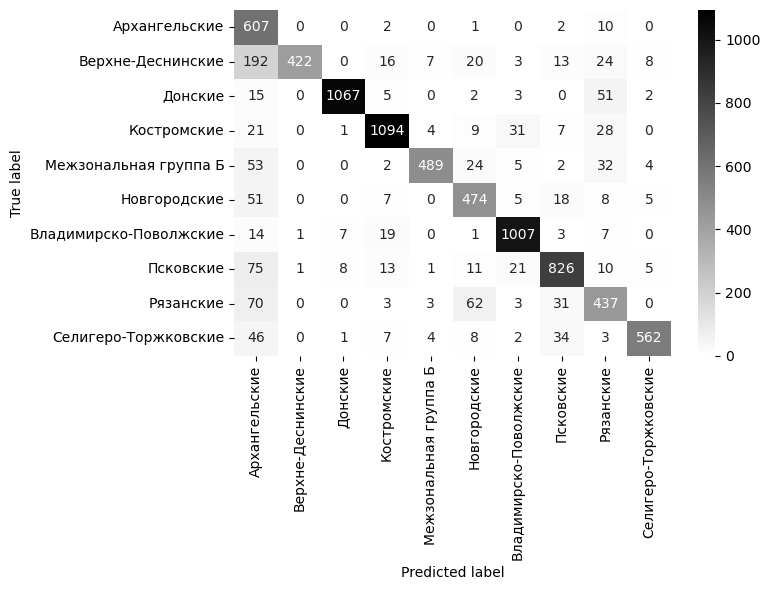

In [50]:
confusion_matrix(test['Variant'], test['predictions'])

# Test on data which not presented in dataset

## Yelets

In [9]:
yelets = pd.read_excel('manifest.xlsx')
yelets = yelets[yelets['corpus']=='Yelets']
yelets['Variant'] = 'Mezhzonalnie'
yelets = yelets[['path', 'Variant']]
yelets['array'] = yelets['path'].progress_apply(read_audio)
yelets['sampling_rate'] = 16000
yelets = yelets[['array', 'Variant']]
yelets['input_features'] = yelets['array'].progress_apply(prepare_dataset)
yelets['predictions'] = yelets['input_features'].progress_apply(get_predictions)
yelets['predictions'].value_counts()

100%|████████████████████████████████████████████████████████████████████████████████| 522/522 [00:39<00:00, 13.29it/s]


Ryazanskie       331
Arkhangelskie    153
Povolzkie         12
Novgorodskie       9
Pskovskie          7
Kostromskie        4
Seligerskie        4
Donskie            1
Mezhzonalnie       1
Name: predictions, dtype: int64

# Pskov

In [11]:
path1 = '/RNC_Pskov/pskov_luch'
pskov1 = [join(path1, f) for f in listdir(path1) if isfile(join(path1, f))]
path2 = '/RNC_Pskov/pskov_vedma'
pskov2 = [join(path2, f) for f in listdir(path2) if isfile(join(path2, f))]
pskov_test_rnc = pskov1 + pskov2
pskov_test_rnc_df = pd.DataFrame(pskov_test_rnc, columns=['path'])
pskov_test_rnc_df['Variant'] = 'Pskovskie'
pskov_test_rnc_df['array'] = pskov_test_rnc_df['path'].progress_apply(read_audio)
pskov_test_rnc_df['sampling_rate'] = 16000
pskov_test_rnc_df = pskov_test_rnc_df[['array', 'Variant']]
pskov_test_rnc_df['input_features'] = pskov_test_rnc_df['array'].progress_apply(prepare_dataset)
pskov_test_rnc_df = pskov_test_rnc_df[pskov_test_rnc_df['array'].str.len()>0]
pskov_test_rnc_df['predictions'] = pskov_test_rnc_df['input_features'].progress_apply(get_predictions)
pskov_test_rnc_df['predictions'].value_counts()

100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:05<00:00, 13.16it/s]


Arkhangelskie    46
Povolzkie         9
Ryazanskie        6
Novgorodskie      4
Donskie           3
Name: predictions, dtype: int64